In [1]:
from data_classes import LAQNData, HealthData, MetData, IncomeData
from ADMS_functions import plot_on_map
from os import path, listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import geopandas as gpd
import zipfile as zpf
import httplib2
from bs4 import BeautifulSoup, SoupStrainer
from openpyxl import load_workbook

/home/users/mwlw3/miniconda3/envs/AQmort/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
tmp_folder = f"/home/users/mwlw3/AQmortality/tmp/"

In [3]:
# Load the income and LAQN datasets

income = IncomeData()
income_df = income.read("income-raw")
income_metadata_df = income.read("income-metadata")

species = "NO2"
region = "London"
NO2 = LAQNData(species, region)
NO2_df = NO2.read("laqn-raw")

wandb: Currently logged in as: michellewl (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Downloading large artifact laqn-raw:latest, 1407.16MB. 198 files... Done. 0:0:0


In [3]:
income_df.head(3)

,E09000004,E09000028,E09000030,E09000002,E09000024,E09000008,E09000001,E09000011,E09000014,E09000003,...,E09000025,E09000023,E09000018,E09000031,E09000026,E09000029,E09000009,E09000027,E09000021,E09000032
1997-01-01,12101.0,10710.0,13085.0,8410.0,16260.0,10214.0,81474.0,13456.0,14170.0,12621.0,...,5910.0,9226.0,13943.0,10461.0,11555.0,11555.0,12923.0,21860.0,14998.0,13863.0
1998-01-01,12181.0,11160.0,13313.0,8667.0,16620.0,10605.0,89776.0,13518.0,14428.0,13337.0,...,6423.0,9563.0,14162.0,10688.0,11777.0,11899.0,13277.0,22318.0,15227.0,15435.0
1999-01-01,12615.0,12042.0,14068.0,9154.0,17510.0,11418.0,82581.0,14244.0,15279.0,14019.0,...,7143.0,10315.0,14953.0,11377.0,12238.0,12489.0,13990.0,23139.0,15992.0,17124.0


In [4]:
NO2_df.head(3)

,EA1,BN2,A30,BX7,BX1,BP0,CR2,BY7,BT7,BT5,...,WM9,WM0,WL4,WMB,WM5,WM8,WMD,WMC,WMA,WMZ
1996-01-01 00:00:00,52.3,NaN,NaN,NaN,NaN,NaN,49.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-01 01:00:00,55.8,NaN,NaN,NaN,61.2,65.0,48.3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-01 02:00:00,62.3,NaN,NaN,NaN,63.1,76.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Download the LAQN site metadata

london_sites = requests.get("http://api.erg.kcl.ac.uk/AirQuality/Information/MonitoringSites/GroupName=London/Json")
london_sites_df = pd.DataFrame(london_sites.json()['Sites']['Site'])
london_sites_df = london_sites_df.loc[london_sites_df["@Latitude"]!=""]
london_sites_df = london_sites_df.loc[london_sites_df["@Latitude"].astype(float)>51]

lat = london_sites_df["@Latitude"].values
lon = london_sites_df["@Longitude"].values

# Create a geopandas dataframe

site_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lon, lat))

In [14]:
site_gdf.to_file(path.join(tmp_folder, "LAQN_sites", "LAQN_site_coordinates.shp"))

In [4]:
# Load the LAQN site shapefile

site_gdf = gpd.read_file(path.join(tmp_folder, "LAQN_sites", "LAQN_site_coordinates.shp"))

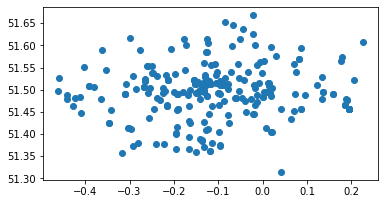

In [17]:
site_gdf.plot()
plt.show()

In [10]:
# Get the web links for the borough & ward coordinate data files

web_address = "https://data.london.gov.uk/dataset/i-trees-canopy-ward-data"

status, response = httplib2.Http().request(web_address)
link_dict = {}

for link in BeautifulSoup(response, parse_only=SoupStrainer('a')):
    if link.has_attr('href') and link["href"].split(".")[-1]=="zip":
        link_dict[link['href'].split("/")[-1].split(".")[0]] = f"https://data.london.gov.uk/{link['href']}"

In [51]:
# Download the borough & ward coordinate data files and unzip them

for url in link_dict.values():
    request = requests.get(url)
    filepath = path.join(tmp_folder, "i-Trees", path.basename(url))
    file = open(filepath, 'wb')
    file.write(request.content)
    file.close()
    zpf.ZipFile(filepath, 'r').extractall(path.join(tmp_folder, "i-Trees"))

In [58]:
# Compile a geopandas dataframe of the london wards coordinates

london_wards_gdf = gpd.GeoDataFrame()

for borough in link_dict.keys():
    borough_folder = path.join(tmp_folder, "i-Trees", borough)
    shapefiles = [file for file in listdir(borough_folder) if file.split(".")[-1]=="shp"]
    for shapefile in shapefiles:
        gdf = gpd.read_file(path.join(borough_folder, shapefile))
        if london_wards_gdf.empty:
            london_wards_gdf = gdf
        else:
            london_wards_gdf = pd.concat([london_wards_gdf, gdf])
london_wards_gdf.to_file(path.join(tmp_folder, "london_wards_coordinates", "london_wards_coordinates.shp"))

In [5]:
# Load the geopandas dataframe of the london wards coordinates
london_wards_gdf = gpd.read_file(path.join(tmp_folder, "london_wards_coordinates", "london_wards_coordinates.shp"))

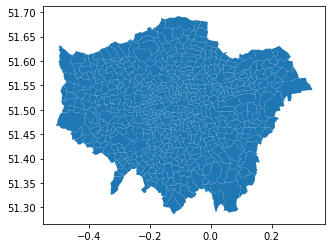

In [12]:
london_wards_gdf.plot()
plt.show()

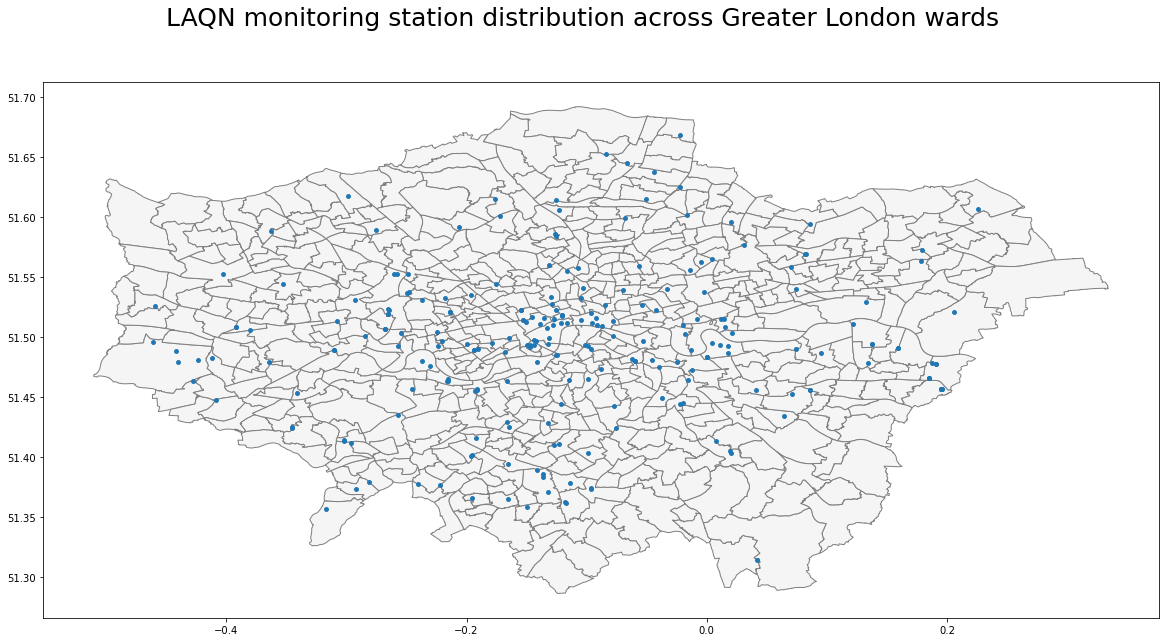

In [13]:
plot_on_map(site_gdf, london_wards_gdf, 
            title="LAQN monitoring station distribution across Greater London wards", 
            data_markersize=15,  
            map_edge_color="gray", axis="on")

### Lookup geographic codes

In [27]:
folderpath = path.join(tmp_folder, "UK_geographic_codes")

In [25]:
download_link = "https://www.arcgis.com/sharing/rest/content/items/03e76a98dbb941e59258f73e06072110/data"
request = requests.get(download_link)
file = open(f"{folderpath}.zip", 'wb')
file.write(request.content)
file.close()
zpf.ZipFile(f"{folderpath}.zip", 'r').extractall(folderpath)

In [28]:
listdir(folderpath)

['RGC_NOVEMBER_2020_UK.csv', 'RGC_NOVEMBER_2020_UK.xlsx']

In [60]:
workbook = load_workbook(path.join(folderpath, listdir(folderpath)[-1]))

In [73]:
contents = pd.DataFrame(workbook[workbook.sheetnames[0]].values)
contents = contents.set_axis(contents.iloc[0], axis="columns")[1:].set_index("Entity code")

In [89]:
contents.head(3)

,Entity name,Entity abbreviation,Entity theme,Entity coverage,Related entity codes,Status,Number of live instances,Number of archived instances,Number of cross-border instances,Date of last instance change,Current code (first in range),Current code (last in range),Reserved code (for CHD use),Entity owner abbreviation,Date entity introduced on RGC,Entity start date
Entity code,,,,,,,,,,,,,,,,
E00,Output Areas,OA,Statistical Building Block,England,"W00, S00, N00",Current,171372,7582,0,2011-12-31 00:00:00,E00000001,E00176774,E00999999,ONS,2009-01-01 00:00:00,2009-01-01 00:00:00
E01,"Super Output Areas, Lower Layer",LSOA,Statistical Building Block,England,"W01, S01",Current,32844,1357,0,2011-12-31 00:00:00,E01000001,E01033768,E01999999,ONS,2009-01-01 00:00:00,2003-01-01 00:00:00
E02,"Super Output Areas, Middle Layer",MSOA,Statistical Building Block,England,"W02, S02",Current,6791,141,0,2011-12-31 00:00:00,E02000001,E02006934,E02999999,ONS,2009-01-01 00:00:00,2003-01-01 00:00:00


In [86]:
def filter_dataframe(dataframe, column_string_dict):
    for column in column_string_dict.keys():
        dataframe = dataframe.loc[dataframe[column].str.contains(column_string_dict[column])]
    return dataframe

In [140]:
# Filter the data tables until you find the Entity code you need

contents_filtered = filter_dataframe(contents, 
                                     {"Entity name": "Borough", 
                                      "Entity coverage": "England", 
                                      "Entity theme": "Administrative"})
sheetname = [sheet for sheet in workbook.sheetnames if contents_filtered.index[0] in sheet][0]
contents_filtered

,Entity name,Entity abbreviation,Entity theme,Entity coverage,Related entity codes,Status,Number of live instances,Number of archived instances,Number of cross-border instances,Date of last instance change,Current code (first in range),Current code (last in range),Reserved code (for CHD use),Entity owner abbreviation,Date entity introduced on RGC,Entity start date
Entity code,,,,,,,,,,,,,,,,
E09,London Boroughs,LONB,Administrative,England,n/a,Current,33,0,0,n/a,E09000001,E09000033,E09999999,MHCLG,2009-01-01 00:00:00,2009-01-01 00:00:00


### Combine the GDHI local authority data with the London wards map

In [6]:
codes_df = income_metadata_df

In [7]:
# Choose a year to plot for the GDHI and assign it to the London wards by borough

year = "2018"

london_wards_gdf[f"GDHI_{year}"] = np.zeros(len(london_wards_gdf))

for local_authority_code in income_df.loc[f"{year}-01-01"].index:
    annual_GDHI = income_df.loc[f"{year}-01-01"][local_authority_code]
    local_authority_name = codes_df.loc[local_authority_code].values[0]
    london_wards_gdf.loc[london_wards_gdf["BOROUGH"].str.contains(local_authority_name), f"GDHI_{year}"] = annual_GDHI

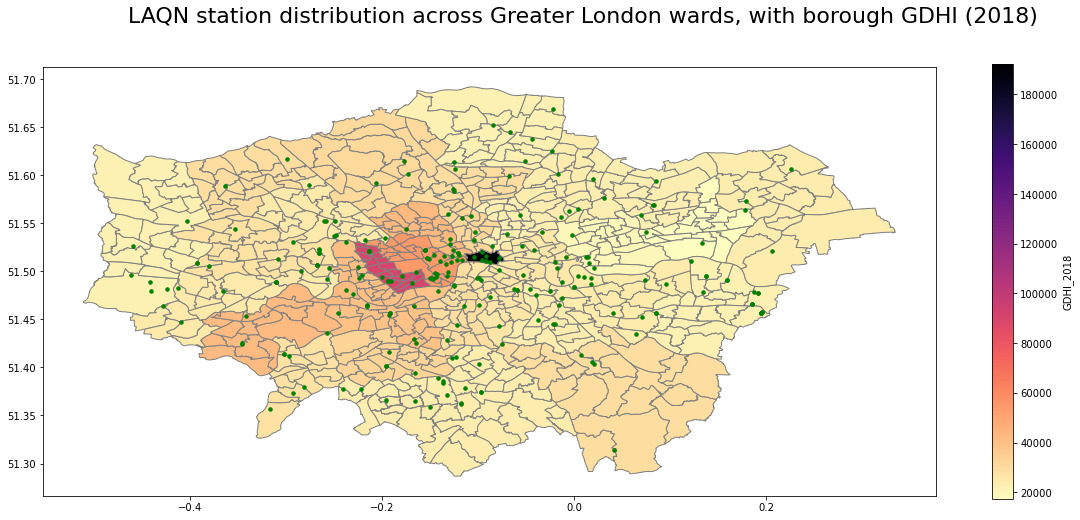

In [81]:
plot_on_map(site_gdf, 
            london_wards_gdf, 
            map_column=f"GDHI_{year}", 
            map_cmap="magma_r", 
            title=f"LAQN station distribution across Greater London wards, with borough GDHI ({year})", 
            figsize=(20, 8), 
            fontsize="22", 
            data_color="green", 
            map_colorbar=True, 
            data_markersize=12, 
            map_color=None, 
            map_edge_color="gray", 
            axis="on")